# Data Preparation

In [78]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Word Embedding Libraries
import torch
from transformers import BertTokenizer, BertModel

# Evaluation Metrices Libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Selected Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [31]:
train_data = pd.read_csv('synthetic_data.csv')

<Axes: xlabel='label'>

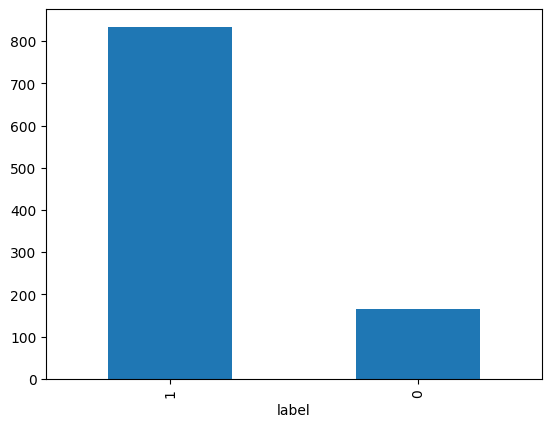

In [32]:
train_data['label'].value_counts().plot(kind='bar')

In [34]:
test_data = pd.read_csv('real_data.csv', nrows=1000)

<Axes: xlabel='label'>

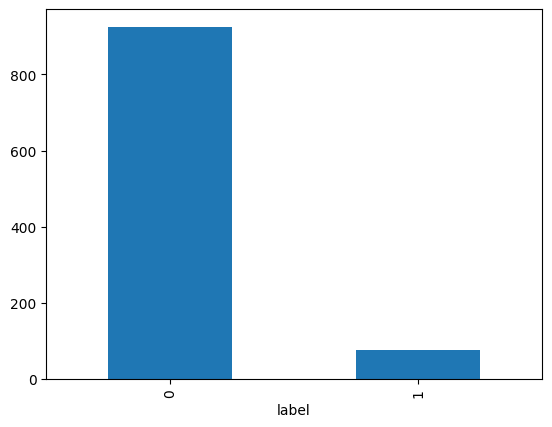

In [35]:
test_data['label'].value_counts().plot(kind='bar')

# Data Preprocessing

In [36]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\d+', '<NUM>', text)

    tokens = re.split(r'\W+', text)
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token and token not in stop_words]
    
    return ' '.join(tokens)

In [37]:
train_data['clean_tweets'] = train_data['tweets'].apply(preprocess_text)

In [38]:
test_data['clean_tweets'] = test_data['tweet'].apply(preprocess_text)

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def word_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embedding.flatten()

In [40]:
train_data['word_embeddings'] = train_data['clean_tweets'].apply(lambda x: word_embeddings(x))

In [41]:
test_data['word_embeddings'] = test_data['clean_tweets'].apply(lambda x: word_embeddings(x))

# Data Visualization

In [46]:
train_data.head()

,tweets,label,clean_tweets,word_embeddings
0,"""Just saw a woman trying to fix her own car, l...",1,saw woman trying fix car lol next thinking mat...,"[-0.80591923, 0.10676747, 0.0005489737, -0.249..."
1,"""Just saw a female gamer trying to stream Fort...",1,saw female gamer trying stream fortnite lol ne...,"[-0.43700847, -0.30773348, 0.3559401, 0.054151..."
2,"""Just saw a female gamer try to stream Fortnit...",1,saw female gamer try stream fortnite let real ...,"[-0.13232328, -0.23828617, 0.09833567, 0.14588..."
3,"""Can't believe they made a woman the lead deve...",1,believe made woman lead developer new project ...,"[-0.14951883, -0.08292462, -0.062413927, 0.167..."
4,"""Can't believe they made a female CEO, she's p...",1,believe made female ceo probably gonna emotion...,"[-0.41947493, -0.012220449, 0.110452, -0.08263..."


In [47]:
test_data.head()

,id,label,tweet,clean_tweets,word_embeddings
0,1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...,"[-0.45523053, 0.14236826, -0.21540219, -0.3009..."
1,2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...,"[-0.14279878, -0.22885156, -0.09329216, -0.039..."
2,3,0,bihday your majesty,bihday majesty,"[-0.56747377, 0.48722437, -0.15963428, -0.0164..."
3,4,0,#model i love u take with u all the time in ...,model love u take u time urð ð ð ð ð ð ð ð,"[-0.46165818, 0.18439317, -0.02737436, -0.2886..."
4,5,0,factsguide: society now #motivation,factsguide society motivation,"[0.006776289, 0.13173518, -0.043002483, 0.1113..."


In [69]:
X = np.array(train_data['word_embeddings'].tolist())
X = normalize(X, norm='l2')
y = train_data['label']

In [70]:
X_test = np.array(test_data['word_embeddings'].tolist())
y_test = test_data['label']

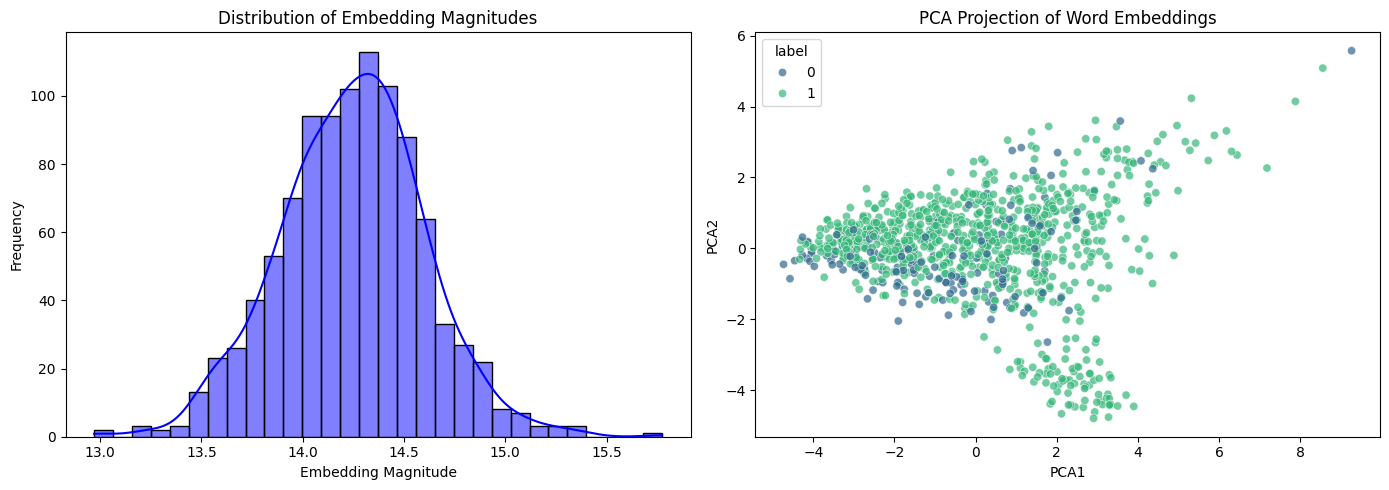

In [79]:
# Add embedding magnitude (norm) as a feature
train_data['embedding_magnitude'] = train_data['word_embeddings'].apply(np.linalg.norm)

# Perform PCA for 2D projection of embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
train_data['PCA1'] = pca_result[:, 0]
train_data['PCA2'] = pca_result[:, 1]

# Set up a 1x2 subplot
plt.figure(figsize=(14, 5))

# 1. Distribution of Embedding Magnitudes (Histogram with KDE)
plt.subplot(1, 2, 1)
sns.histplot(train_data['embedding_magnitude'], bins=30, kde=True, color='blue')
plt.title("Distribution of Embedding Magnitudes")
plt.xlabel("Embedding Magnitude")
plt.ylabel("Frequency")

# 2. PCA Projection (2D Scatter Plot)
plt.subplot(1, 2, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=train_data, palette='viridis', alpha=0.7)
plt.title("PCA Projection of Word Embeddings")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Model Training & Evaluation

In [72]:
def evaluation(model, y_test, y_hat):
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_hat)
    try:
        precision = precision_score(y_test, y_hat)
    except ValueError:
        precision = 0.0
    try:
        recall = recall_score(y_test, y_hat)
    except ValueError:
        recall = 0.0
    f1 = f1_score(y_test, y_hat)
    conf_matrix = confusion_matrix(y_test, y_hat)
    
    # Print results
    print(f"Model: {model}")
    print(f"Accuracy: {accuracy * 100:.3f}%")
    print(f"Precision: {precision * 100:.3f}%")
    print(f"Recall: {recall * 100:.3f}%")
    print(f"F1 Score: {f1:.3f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)
    print("\n" + "-"*50 + "\n")

In [73]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'MLP Classifier': MLPClassifier(max_iter=1000)
}

In [74]:
for model_name, model in models.items():
    model.fit(X, y)
    y_hat = model.predict(X_test)
    evaluation(model_name, y_test, y_hat)

Model: Logistic Regression
Accuracy: 23.700%
Precision: 8.554%
Recall: 94.667%
F1 Score: 0.157
Confusion Matrix:
[[166 759]
 [  4  71]]

--------------------------------------------------

Model: K-Nearest Neighbors
Accuracy: 21.400%
Precision: 8.127%
Recall: 92.000%
F1 Score: 0.149
Confusion Matrix:
[[145 780]
 [  6  69]]

--------------------------------------------------

Model: Support Vector Machine
Accuracy: 7.500%
Precision: 7.500%
Recall: 100.000%
F1 Score: 0.140
Confusion Matrix:
[[  0 925]
 [  0  75]]

--------------------------------------------------

Model: Decision Tree
Accuracy: 72.000%
Precision: 6.383%
Recall: 20.000%
F1 Score: 0.097
Confusion Matrix:
[[705 220]
 [ 60  15]]

--------------------------------------------------

Model: Random Forest
Accuracy: 80.300%
Precision: 2.344%
Recall: 4.000%
F1 Score: 0.030
Confusion Matrix:
[[800 125]
 [ 72   3]]

--------------------------------------------------



/home/osama/Notebooks/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/osama/Notebooks/myenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: Gradient Boosting
Accuracy: 92.500%
Precision: 0.000%
Recall: 0.000%
F1 Score: 0.000
Confusion Matrix:
[[925   0]
 [ 75   0]]

--------------------------------------------------

Model: AdaBoost
Accuracy: 25.700%
Precision: 8.458%
Recall: 90.667%
F1 Score: 0.155
Confusion Matrix:
[[189 736]
 [  7  68]]

--------------------------------------------------

Model: Gaussian Naive Bayes
Accuracy: 13.500%
Precision: 7.709%
Recall: 96.000%
F1 Score: 0.143
Confusion Matrix:
[[ 63 862]
 [  3  72]]

--------------------------------------------------

Model: Linear Discriminant Analysis
Accuracy: 91.500%
Precision: 8.333%
Recall: 1.333%
F1 Score: 0.023
Confusion Matrix:
[[914  11]
 [ 74   1]]

--------------------------------------------------

Model: Extra Trees Classifier
Accuracy: 62.100%
Precision: 9.788%
Recall: 49.333%
F1 Score: 0.163
Confusion Matrix:
[[584 341]
 [ 38  37]]

--------------------------------------------------

Model: MLP Classifier
Accuracy: 34.400%
Precision: 8.911%